<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/Position%2BMLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# 1. Load data
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
# Step 1: Upload the file (you already did this once, but keep for completeness)
uploaded = files.upload()

# Step 2: Load the uploaded CSV file
# Replace 'cf_pair25_v1.csv' with the exact filename you uploaded
data = pd.read_csv('cf_pair25_v1.csv')

Saving cf_pair25_v1.csv to cf_pair25_v1.csv


In [ ]:
data["Vehicle_ID_f"].unique()
vehicle_ids = data["Vehicle_ID_f"].unique()
N = len(vehicle_ids)
vehicle_ids_eval=data["Vehicle_ID_f"].unique()[-5:]
vehicle_ids_crossval=data["Vehicle_ID_f"].unique()[:-5]
N_eval=len(vehicle_ids_eval)
N_crossval=len(vehicle_ids_crossval)
print([int(x) for x in vehicle_ids_eval])  #should be 12638, 10 , 9683, 3054, 5167

[12638, 10, 9683, 3054, 5167]


In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- Load data ---
df = pd.read_csv('cf_pair25_v1.csv')

# --- IDM model ---
def idm_model(s, v, delta_v, params, T=1.5, v0=30, s0=1):
    a, b = params
    delta = 4
    s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))
    acceleration = a * (1 - (v / v0) ** delta - (s_star / s) ** 2)
    return acceleration

# --- Log-likelihood function (based on position) ---
def log_likelihood_position(params, df, time_step=0.1, sigma=1.0):
    total_ll = 0
    grouped = df.groupby('Vehicle_ID_f')

    for vehicle_id, data in grouped:
        # Initial follower state
        v_f = data['v_f'].iloc[0]
        x_f = data['x_f'].iloc[0]

        # Leader trajectories
        v_l = data['v_l'].values
        x_l = data['x_l'].values

        # Observed follower positions
        x_obs = data['x_f'].values

        # Initialize simulated trajectories
        v_sim = [v_f]
        x_sim = [x_f]

        # Step through trajectory
        for i in range(1, len(data)):
            s = x_l[i] - x_sim[-1] - data['length_l'].iloc[i]
            delta_v = v_sim[-1] - v_l[i]

            acc = idm_model(s, v_sim[-1], delta_v, params)

            new_v = v_sim[-1] + acc * time_step
            new_x = x_sim[-1] + new_v * time_step

            v_sim.append(new_v)
            x_sim.append(new_x)

        # Gaussian log-likelihood on position
        residuals = x_obs - np.array(x_sim)
        ll = -0.5 * np.sum((residuals / sigma) ** 2 + np.log(2 * np.pi * sigma**2))
        total_ll += ll

    return -total_ll  # Negative log-likelihood for minimization

# --- Cross-validation ---
initial_guess = [1.0, 2.0]
bounds = [(0.1, 5.0), (0.1, 5.0)]

all_params = []
vehicle_ids = df["Vehicle_ID_f"].unique()
N = len(vehicle_ids)
N_crossval = N - 5  # leave last 5 for evaluation

for start in range(0, N_crossval, 5):
    test_ids = vehicle_ids[start:start+5]
    train_ids = np.setdiff1d(vehicle_ids, test_ids)
    print("Test IDs:", test_ids)

    train_df = df[df["Vehicle_ID_f"].isin(train_ids)]
    test_df  = df[df["Vehicle_ID_f"].isin(test_ids)]

    # 1. Calibration (MLE on training set, position)
    result = minimize(log_likelihood_position, initial_guess, args=(train_df,), bounds=bounds, method='L-BFGS-B')
    params = result.x
    print("Calibrated params (position):", params)
    all_params.append(params)

    # 2. Testing (evaluate likelihood on test set)
    test_ll = log_likelihood_position(params, test_df)
    print("Test log-likelihood (position):", -test_ll)

# Mean parameters across folds
mean_params = np.mean(np.array(all_params), axis=0)
print("Mean calibrated params (position):", mean_params)


Test IDs: [1939. 2740. 2933. 4189.   26.]
Calibrated params (position): [0.37178471 0.37247727]
Test log-likelihood (position): -15786.244585214663
Test IDs: [ 2856.    15. 12043.  8809. 12166.]
Calibrated params (position): [0.34023743 0.36645462]
Test log-likelihood (position): -13257.231476304583
Test IDs: [9.0000e+00 4.0940e+03 1.0768e+04 1.3420e+03 6.5340e+03]
Calibrated params (position): [0.34990475 0.2690429 ]
Test log-likelihood (position): -11732.604344989993
Test IDs: [ 2259.  4330.  3817.  5763. 10069.]
Calibrated params (position): [0.34764567 0.31257089]
Test log-likelihood (position): -18036.051969756136
Mean calibrated params (position): [0.35239314 0.33013642]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def validate_idm_full(eval_df, params, time_step=0.1, sigma=1.0, show_plots=True):
    """
    Validate IDM on an evaluation dataset.
    Returns per-vehicle diagnostics and plots trajectories.

    Args:
        eval_df: evaluation DataFrame
        params: calibrated IDM parameters [a, b]
        time_step: simulation timestep
        sigma: assumed noise for LL on acceleration
        show_plots: whether to plot trajectories
    Returns:
        per_vehicle: dict with per-vehicle LL and RMSE diagnostics
    """
    per_vehicle = {}

    grouped = eval_df.groupby("Vehicle_ID_f")

    for vehicle_id, data in grouped:
        # Observed trajectories
        v_obs = data["v_f"].values
        x_obs = data["x_f"].values
        a_obs = data["a_f"].values
        v_l = data["v_l"].values
        x_l = data["x_l"].values
        lengths = data["length_l"].values

        # Initialize simulation
        v_sim = [v_obs[0]]
        x_sim = [x_obs[0]]
        a_sim = [a_obs[0]]
        s_sim = [x_l[0] - x_obs[0] - lengths[0]]

        # Simulate forward
        for i in range(1, len(data)):
            s = x_l[i] - x_sim[-1] - lengths[i]
            delta_v = v_sim[-1] - v_l[i]
            acc = idm_model(s, v_sim[-1], delta_v, params)

            v_next = v_sim[-1] + acc * time_step
            x_next = x_sim[-1] + v_next * time_step

            v_sim.append(v_next)
            x_sim.append(x_next)
            a_sim.append(acc)
            s_sim.append(s)

        # Convert to arrays
        v_sim = np.array(v_sim)
        x_sim = np.array(x_sim)
        a_sim = np.array(a_sim)
        s_sim = np.array(s_sim)
        s_obs = x_l - x_obs - lengths

        # Compute per-vehicle diagnostics
        LL_acc = np.sum(norm.logpdf(a_obs, loc=a_sim, scale=sigma))
        RMSE_acc = np.sqrt(np.mean((a_obs - a_sim)**2))
        RMSE_speed = np.sqrt(np.mean((v_obs - v_sim)**2))
        RMSE_pos = np.sqrt(np.mean((x_obs - x_sim)**2))
        RMSE_spacing = np.sqrt(np.mean((s_obs - s_sim)**2))

        per_vehicle[vehicle_id] = {
            "LL_acc": LL_acc,
            "RMSE_acc": RMSE_acc,
            "RMSE_speed": RMSE_speed,
            "RMSE_pos": RMSE_pos,
            "RMSE_spacing": RMSE_spacing
        }

        # --- Plots ---
        if show_plots:
            t = np.arange(len(data)) * time_step

            plt.figure(figsize=(10,4))
            plt.plot(t, v_l, label="Leader speed")
            plt.plot(t, v_obs, label="Observed follower speed")
            plt.plot(t, v_sim, "--", label="Predicted follower speed")
            plt.title(f"Vehicle {vehicle_id} - Speed")
            plt.xlabel("Time (s)")
            plt.ylabel("Speed (m/s)")
            plt.legend()
            plt.show()

            plt.figure(figsize=(10,4))
            plt.plot(t, x_l, label="Leader position")
            plt.plot(t, x_obs, label="Observed follower position")
            plt.plot(t, x_sim, "--", label="Predicted follower position")
            plt.title(f"Vehicle {vehicle_id} - Position")
            plt.xlabel("Time (s)")
            plt.ylabel("Position (m)")
            plt.legend()
            plt.show()

            plt.figure(figsize=(10,4))
            plt.plot(t, a_obs, label="Observed acceleration")
            plt.plot(t, a_sim, "--", label="Predicted acceleration")
            plt.title(f"Vehicle {vehicle_id} - Acceleration")
            plt.xlabel("Time (s)")
            plt.ylabel("Acceleration (m/s²)")
            plt.legend()
            plt.show()

            plt.figure(figsize=(10,4))
            plt.plot(t, s_obs, label="Observed spacing")
            plt.plot(t, s_sim, "--", label="Predicted spacing")
            plt.title(f"Vehicle {vehicle_id} - Spacing")
            plt.xlabel("Time (s)")
            plt.ylabel("Spacing (m)")
            plt.legend()
            plt.show()

    return per_vehicle


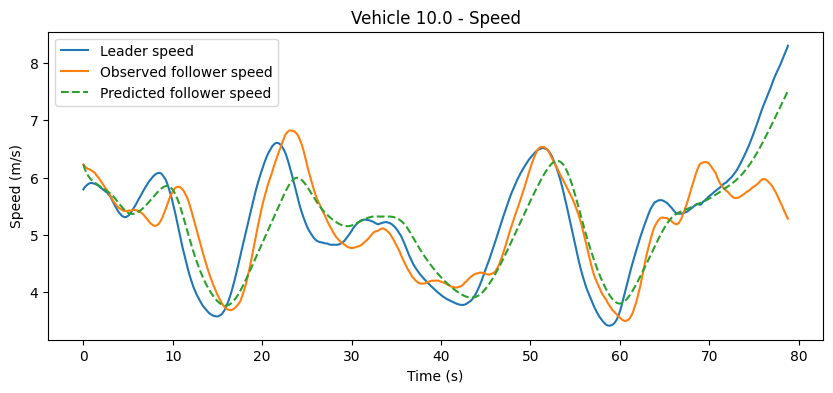

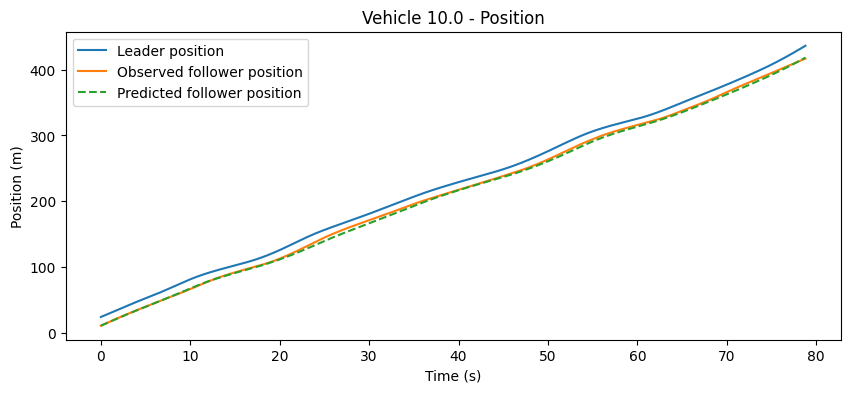

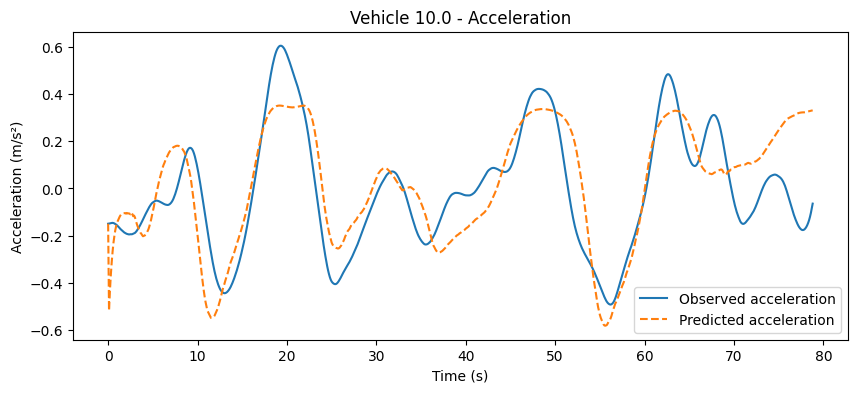

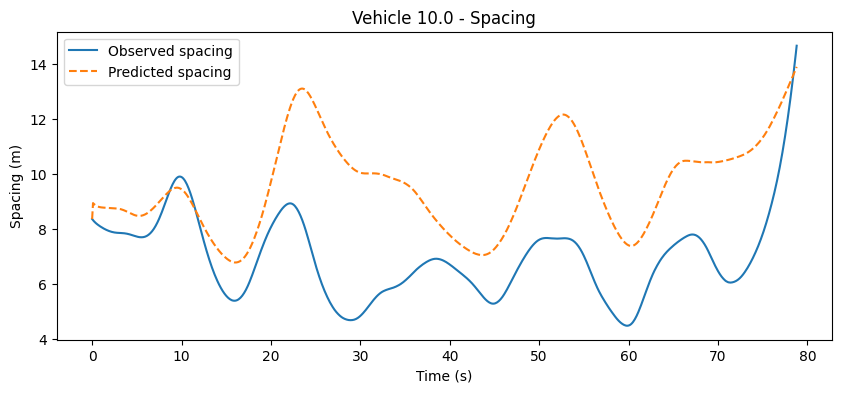

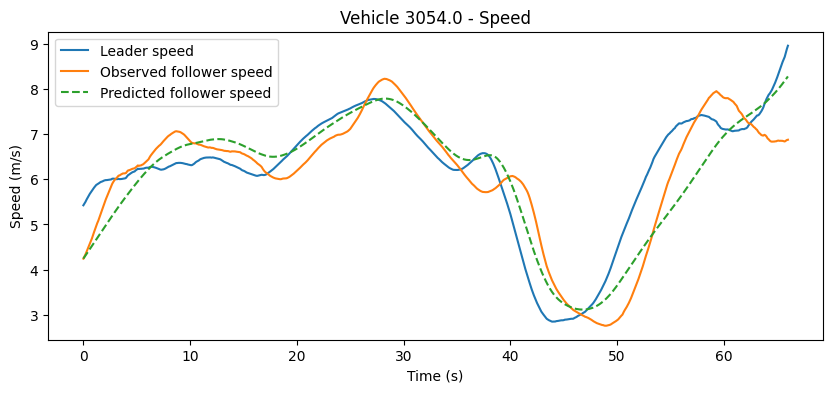

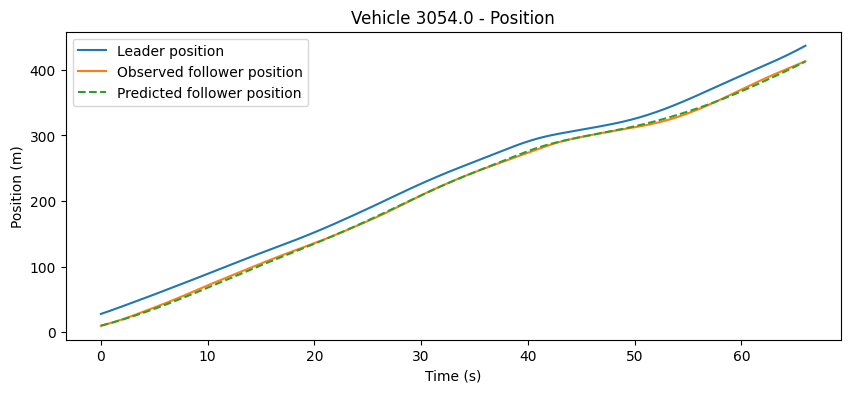

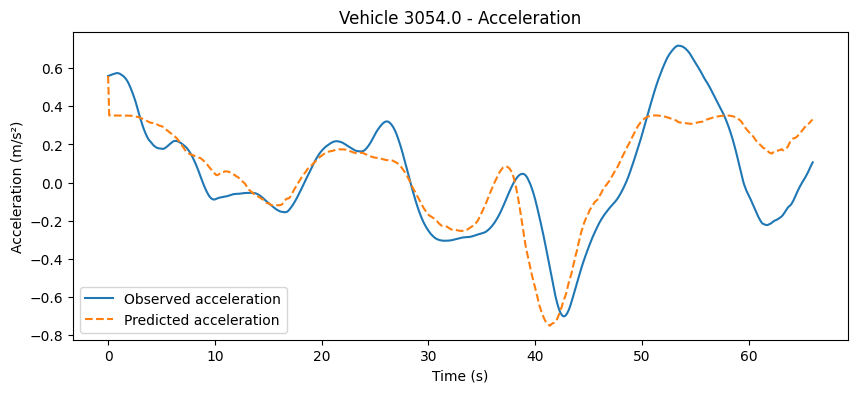

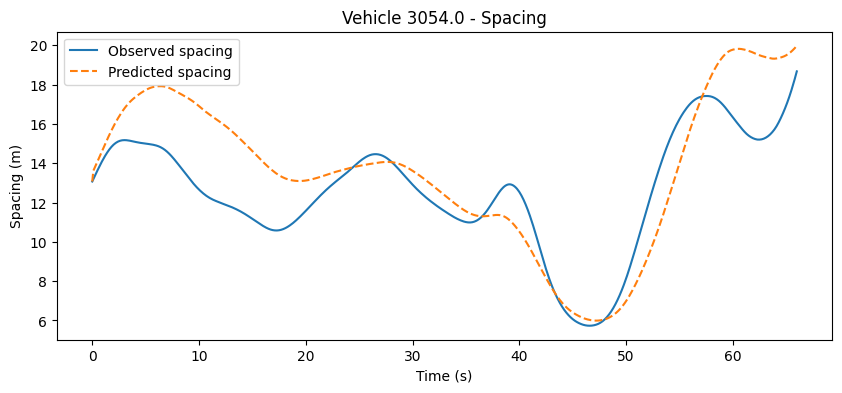

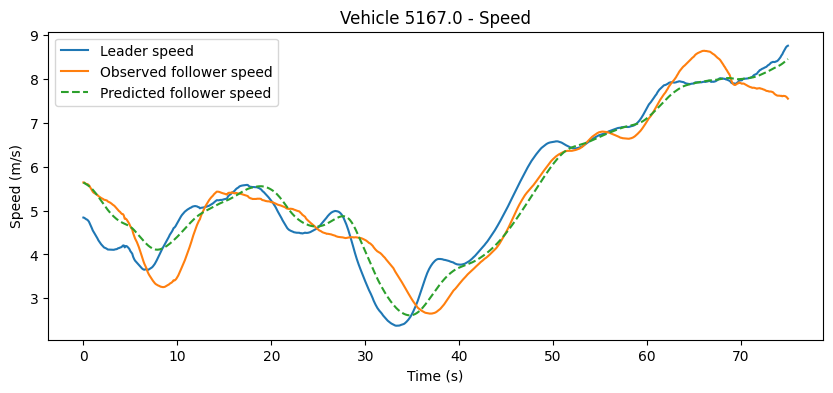

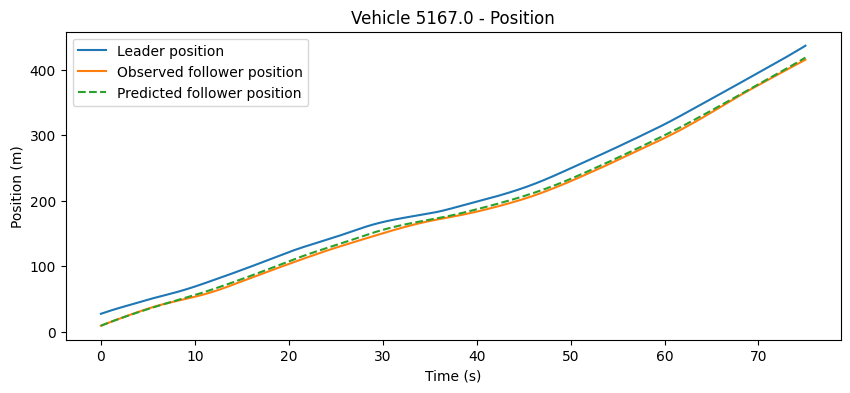

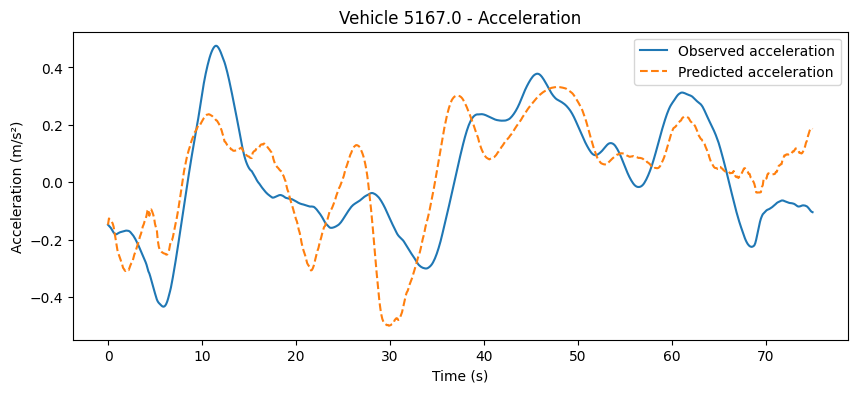

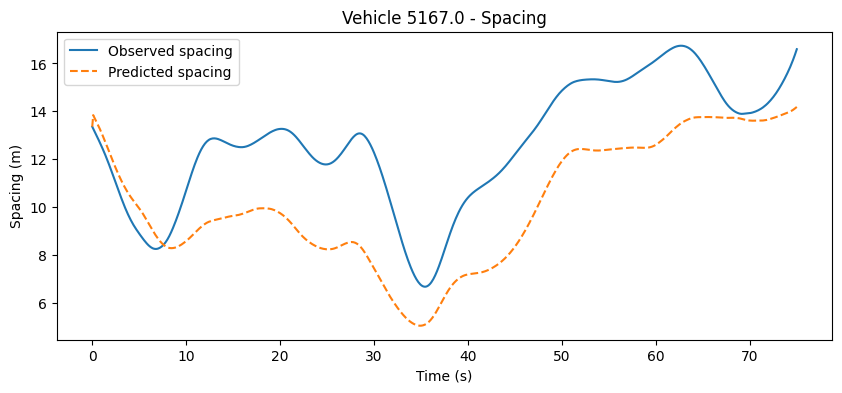

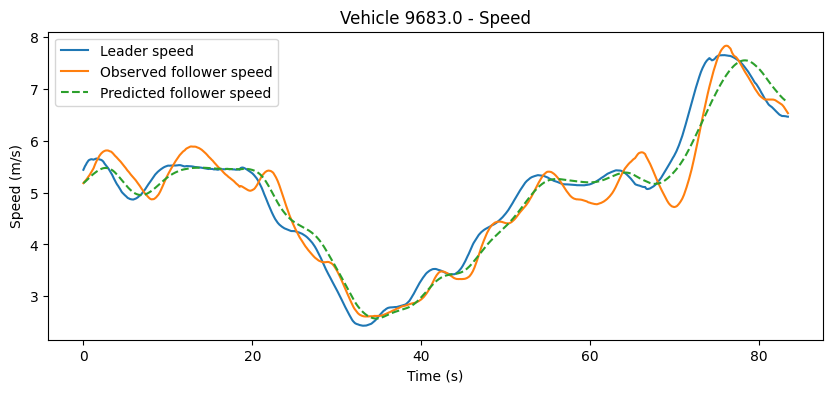

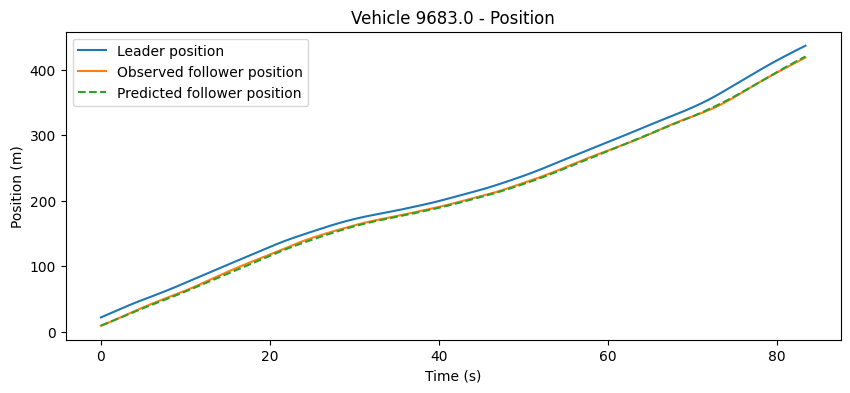

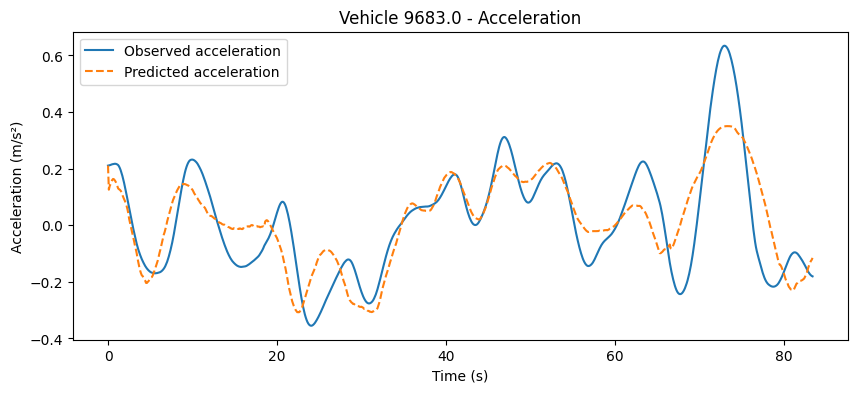

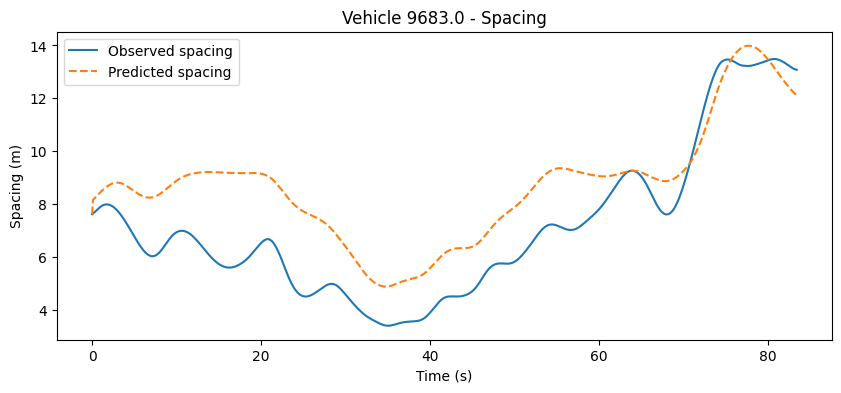

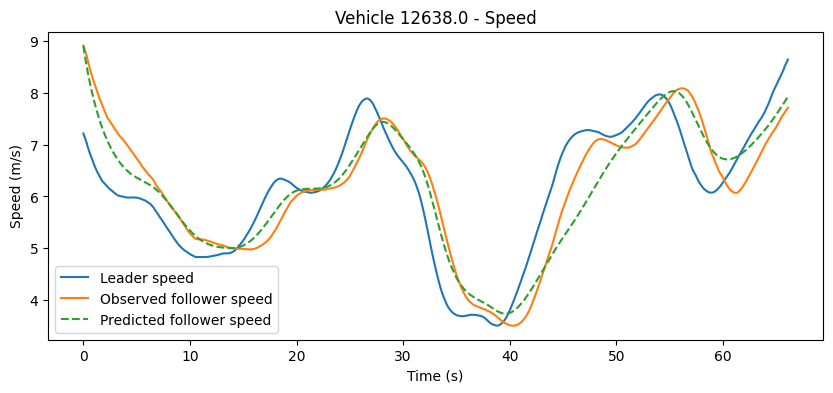

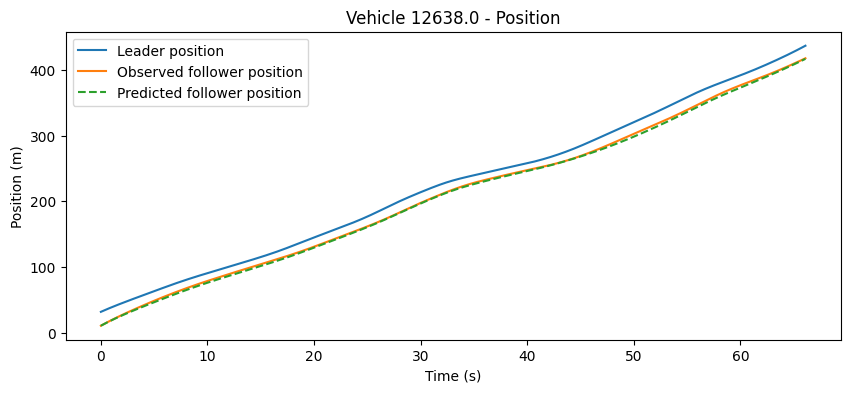

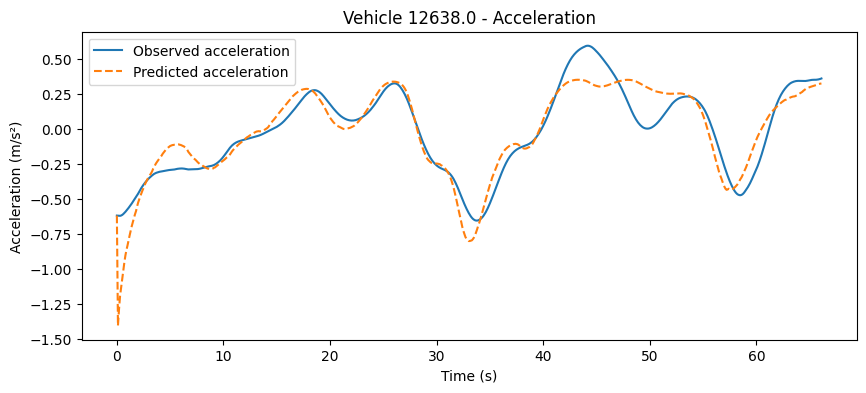

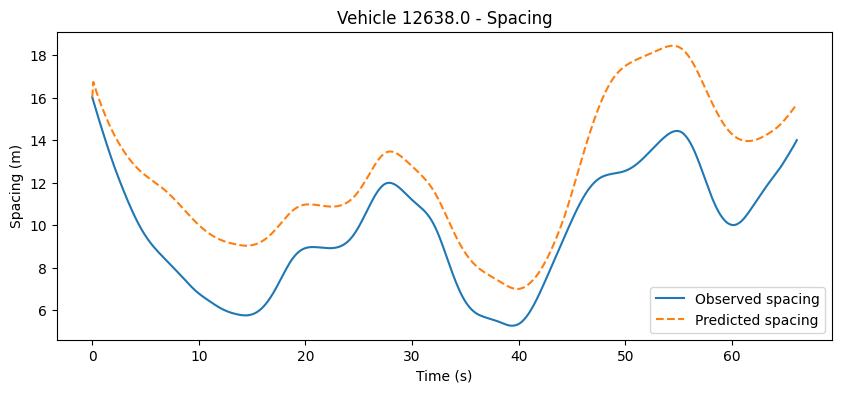

Vehicle 10.0: {'LL_acc': np.float64(-735.948822369427), 'RMSE_acc': np.float64(0.16627065503214036), 'RMSE_speed': np.float64(0.46711178532948977), 'RMSE_pos': np.float64(2.6540972583743017), 'RMSE_spacing': np.float64(3.0899612586784917)}
Vehicle 3054.0: {'LL_acc': np.float64(-619.318304495499), 'RMSE_acc': np.float64(0.18975208004823962), 'RMSE_speed': np.float64(0.5423950098602061), 'RMSE_pos': np.float64(1.9889654566817956), 'RMSE_spacing': np.float64(2.255378901622375)}
Vehicle 5167.0: {'LL_acc': np.float64(-698.8349706059424), 'RMSE_acc': np.float64(0.152320114326105), 'RMSE_speed': np.float64(0.37980391349835685), 'RMSE_pos': np.float64(3.3504367321076898), 'RMSE_spacing': np.float64(2.8806129734249026)}
Vehicle 9683.0: {'LL_acc': np.float64(-772.9200634894362), 'RMSE_acc': np.float64(0.11588129651810697), 'RMSE_speed': np.float64(0.2822498640329651), 'RMSE_pos': np.float64(1.544551241900853), 'RMSE_spacing': np.float64(1.876784199823482)}
Vehicle 12638.0: {'LL_acc': np.float64(

In [5]:
# evaluation set: last 5 vehicles
eval_df = df[df["Vehicle_ID_f"].isin(vehicle_ids[-5:])]

# validate with calibrated parameters
eval_results = validate_idm_full(eval_df, mean_params, sigma=1.0, show_plots=True)

# inspect results per vehicle
for vid, metrics in eval_results.items():
    print(f"Vehicle {vid}: {metrics}")

# --- Compute averages across all vehicles ---
# Convert to DataFrame for convenience
import pandas as pd

df_metrics = pd.DataFrame(eval_results).T   # transpose so vehicles are rows
avg_metrics = df_metrics.mean()

print("\n--- Average across all vehicles ---")
print(avg_metrics.to_dict())

